In [1]:
# Disable tensorflow logging
import tensorflow as tf
import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [2]:
# Specific instruction to run the notebooks from a sub-folder.
import sys
sys.path.append("..")

In [3]:
import logging
from bugfinder.settings import LOGGER

from os.path import join, exists, basename, dirname
from shutil import rmtree, copytree

import tensorflow as tf
from pprint import pprint
from copy import deepcopy
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xlsxwriter

In [4]:
# Setup logging to only output INFO level messages
LOGGER.setLevel(logging.INFO)
LOGGER.propagate = False

In [5]:
def prep_weights(input_weights, log=False):
    w_prep = list()
    
    for value in input_weights.values():
        last_col = value.columns[-1]
        w_prep.append(
            deepcopy(value.drop([last_col], axis=1).values.tolist())
        )
        
    return w_prep

def final_weights(input_weights, log=False):
    size = [len(layer[0]) for layer in input_weights]
    final_weights = np.zeros(size, dtype=np.float32)

    iterator = np.nditer(final_weights, flags=['multi_index'])
    for _ in iterator:
        idx = iterator.multi_index
        v = 1
        for n in range(len(idx) - 1):
            if log:
                print(f"Getting {n},{idx[n+1]},{idx[n]}: {input_weights[n].shape}")
            v *= input_weights[n][idx[n+1]][idx[n]]

        final_weights[idx] = v * input_weights[-1][0][idx[-1]]
        
    return final_weights

def revise_node_weights(node_weights, min_bound=0, max_bound=1):
    abs_values = np.abs(node_weights)
    min_value = np.min(abs_values)
    max_value = np.max(abs_values)
    
    if min_value == max_value:
        revised_node_weights = [0 for _ in abs_values]
    else:
        normalized_weights = [
            min_bound + (max_bound - min_bound) * (v - min_value) / (max_value - min_value) 
            for v in abs_values
        ]
        threshold = np.median(normalized_weights) - 0.5 * np.std(normalized_weights)

        revised_node_weights = [get_val(v, threshold) for v in normalized_weights]
    
    return revised_node_weights

def get_val(val, thr):
    return val if val >= thr else 0

def init_model(model_dir, model_arch, feat_count):
    # Renaming input columns to avoid forbidden characters
    columns = [
        f"feat{feature_nb}" for feature_nb in range(feat_count)
    ]

    model = tf.estimator.DNNClassifier(
        hidden_units = model_arch,
        feature_columns=[
            tf.feature_column.numeric_column(col) for col in columns
        ],
        n_classes=2,
        model_dir=model_dir,
    )

    return model, columns

In [6]:
model_dir = "/home/pnd/model23"
model_arch = [10, 10, 10]
feat_count = 632
        
model, columns = init_model(
    model_dir, 
    model_arch, 
    feat_count
)

In [7]:
chosen_model_vars = [var for var in model.get_variable_names() if basename(var) == "kernel"]
layers = sorted(set([basename(dirname(var)) for var in chosen_model_vars]))
cols = columns

weights = dict()

for layer in layers:
    kernel = model.get_variable_value(f"dnn/{layer}/kernel").transpose()
    
    layer_weights = np.zeros((kernel.shape[0], kernel.shape[1]+1))
    
    layer_weights[:, :-1] = kernel
    layer_weights[:, -1] = model.get_variable_value(f"dnn/{layer}/bias")
    
    weights[layer] = pd.DataFrame(layer_weights, columns=cols+["bias"])
    
    cols = [f"{layer}_n{index}" for index in range(layer_weights.shape[0])]

In [8]:
# Step 1: correct layer value
new_weights = dict()

for layer in layers:
    layer_values = weights[layer].values
    new_layer_values = list()

    for node_values in layer_values:
        updated_node_values = revise_node_weights(node_values, -1, 1)
        new_layer_values.append(updated_node_values)
        
    new_weights[layer] = pd.DataFrame(
        new_layer_values, columns=[f"c{idx}" for idx in range(len(new_layer_values[0]))]
    )

In [9]:
# Compute weights using orig weights
pww = prep_weights(weights)
fww = final_weights(pww)
fww_abs = np.abs(fww)

In [10]:
# Compute weights using normalized weights
npw = prep_weights(new_weights)
nfw = final_weights(npw)
nfw_abs = np.abs(nfw)

In [11]:
# Compute means
fww_avg = list()
fww_abs_avg = list()
nfw_avg = list()
nfw_abs_avg = list()

for idx in range(len(fww)):
    fww_avg.append(np.mean(fww[idx].flatten()))
    fww_abs_avg.append(np.mean(fww_abs[idx].flatten()))
    nfw_avg.append(np.mean(nfw[idx].flatten()))
    nfw_abs_avg.append(np.mean(nfw_abs[idx].flatten()))

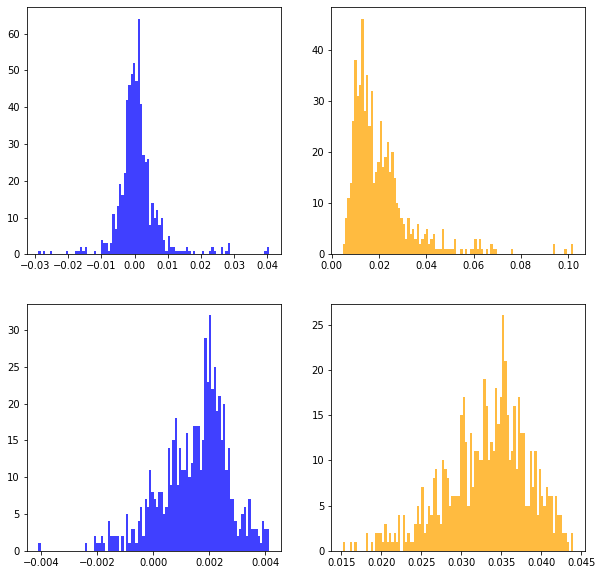

In [12]:
spread = 100
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax[0, 0].hist(fww_avg, spread, color='blue', alpha=0.75)
ax[0, 1].hist(fww_abs_avg, spread, color='orange', alpha=0.75)
ax[1, 0].hist(nfw_avg, spread, color='blue', alpha=0.75)
ax[1, 1].hist(nfw_abs_avg, spread, color='orange', alpha=0.75)
plt.show()

In [13]:
thresholds = [0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
fw_corrs = [deepcopy(fww) for _ in range(len(thresholds))]

print(sum([np.count_nonzero(fw_corr.flatten()) for fw_corr in fw_corrs]) - len(fw_corrs[0].flatten())*len(fw_corrs))

print("Computing...")
for thr_idx, thr_val in tqdm(enumerate(thresholds), total=len(thresholds)):
    for fidx, fv in tqdm(enumerate(fww_abs), desc=f"Threshold: {thr_val}", total=len(fww_abs), leave=False):
        flat = fv.flatten()

        threshold = thr_val * np.std(flat)

        with np.nditer(fw_corrs[thr_idx][fidx], op_flags=['readwrite']) as it:
            for x in it:
                if abs(x) < threshold:
                    x[...] = 0.

print(sum([np.count_nonzero(fw_corr.flatten()) for fw_corr in fw_corrs]) - len(fw_corrs[0].flatten())*len(fw_corrs))

0
Computing...



-3622651


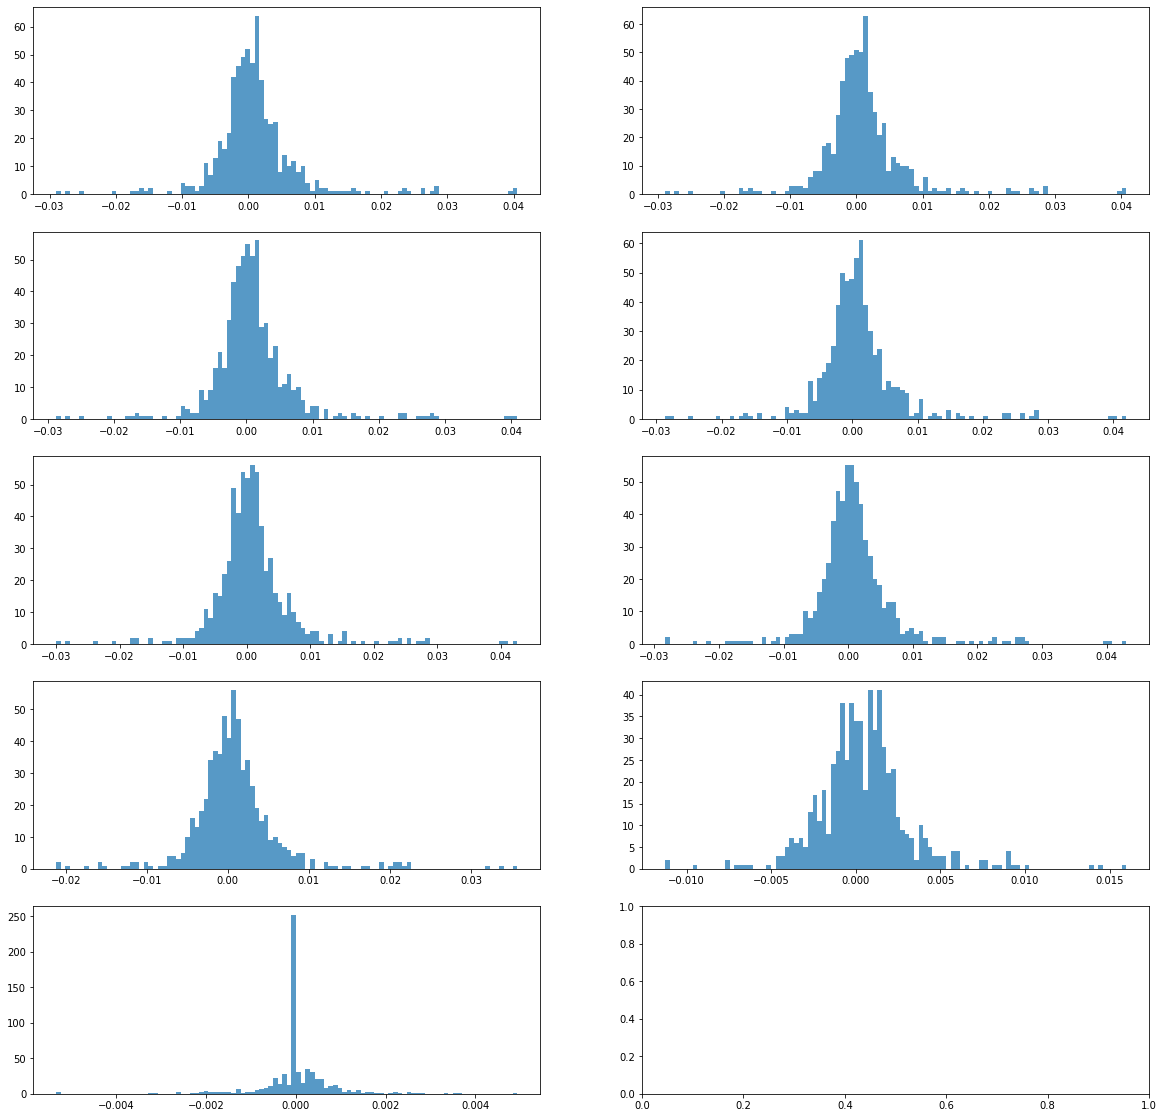

In [14]:
fw_corrs_min = []
fw_corrs_max = []
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

fig_idx = 0
ax[int(np.floor(fig_idx/2)), fig_idx%2].hist(fww_avg, spread, alpha=0.75)

for fw_corr in fw_corrs:
    fw_corr_avg = []
    fig_idx += 1
    for idx in range(len(fww)):
        fw_corr_avg.append(np.mean(fw_corr[idx].flatten()))
        
    fw_corrs_min.append(np.min(fw_corr_avg))
    fw_corrs_max.append(np.max(fw_corr_avg))
    
    ax[int(np.floor(fig_idx/2)), fig_idx%2].hist(fw_corr_avg, spread, alpha=0.75)
    
plt.show()

In [15]:
print(thresholds)
print(fw_corrs_min)
print(fw_corrs_max)

[0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
[-0.028897285, -0.028707534, -0.02866314, -0.029951667, -0.028367609, -0.021168198, -0.0112790745, -0.005330657]
[0.040709466, 0.040936004, 0.04194093, 0.042604707, 0.043039676, 0.03572118, 0.015975032, 0.004937109]


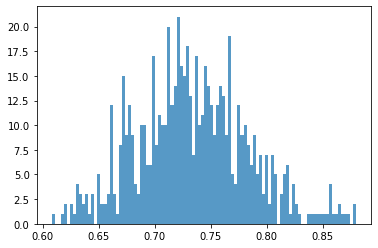

In [16]:
chosen_corr = fw_corrs[3]
zeros = [(ft.size - np.count_nonzero(ft.flatten())) / ft.size for ft in chosen_corr]

plt.hist(zeros, spread, alpha=0.75)
plt.show()

In [27]:
sorted_cols = np.argsort(zeros)
sorted_cols

array([116, 516, 235, 498, 526, 220, 108, 487, 103, 406, 456,  54,  50,
       204, 410, 254, 256, 142, 569,  80, 140, 545, 423,  65, 474,  77,
       570, 520, 306, 563, 270,  73, 212, 495, 216, 333, 318, 630, 163,
       178,  41, 394, 550,  37, 102, 517,  52, 232, 184, 446, 291, 560,
       239, 421, 425, 382, 231, 539, 292, 194, 589, 205,  88,  38, 485,
       253, 571, 128, 453, 187, 315, 177, 468,  10, 342, 118, 438, 221,
       414, 491, 628, 492, 466, 249, 268, 615, 236, 157, 579, 521,  90,
       129, 126, 561, 553, 208, 114, 327, 417, 430, 160, 131, 378,  72,
       138,  12, 554, 625, 154, 602, 502,  48, 486, 443, 240,  33, 618,
       360, 100, 558, 609, 377,  13,  92, 580, 255, 237, 207, 467,   6,
       399, 408, 273, 451, 326, 180, 415, 171, 271,  64, 575, 145, 300,
       434, 198,  68, 181, 139,  31, 537, 470,  91,  43,  85, 125, 427,
       444, 283,  17, 190, 346,  26, 244, 294, 458, 189, 411, 313, 428,
       170, 603,  61, 400, 397, 385, 585, 631,  36, 132, 576, 47

In [34]:
limited_cols = sorted_cols[-150:]
limited_cols

array([222, 280,   9, 112, 356, 358,  20, 322, 455, 206, 310, 552, 197,
       465,  71,  47, 217, 301, 384, 418, 452, 447, 431,  78, 201,  98,
       172, 403, 245, 174, 149, 119, 192, 226, 329, 121, 543, 165, 123,
       344, 588, 362, 339,  51, 144, 308, 227,  63,   8, 522, 199,  74,
       605, 191, 460, 536, 303, 155, 489, 617, 493, 624, 596, 361, 622,
       494,  44, 368, 120, 386,  59, 248, 389, 488, 481, 510, 341, 110,
       472, 252, 141, 505, 260, 518, 606, 228, 290, 587, 133, 193, 258,
       247, 246, 437, 355, 370, 592, 567, 257, 476, 203, 314,  53, 454,
       623, 109, 276, 519, 336, 196, 449, 261, 512, 169, 209, 424, 557,
        79, 267, 436, 459, 332,  95, 503, 325, 380, 398, 612,  94, 202,
       243, 302, 348, 277, 218, 371, 490,  25,  40, 101,  58, 401, 338,
        86, 122, 152, 214,  66, 309, 230])

In [35]:
aiwe = pd.read_csv("../data/aiwe-test-nopca3/sign01.csv")
aiwe_cols = np.array(aiwe.columns)

In [36]:
limited_cols_for_pd = [aiwe_cols[idx] for idx in limited_cols]

In [40]:
new_aiwe = aiwe.drop(aiwe.columns.difference(limited_cols_for_pd), axis=1)
new_aiwe.to_csv("../data/aiwe-test-nopca3/sign01-lim.csv", index=False)